## Action要求：

#### 文本抄袭自动检测分析: 如果你是某新闻单位工作人员（这里假设source=新华社），为了防止其他媒体抄袭你的文章，你打算做一个抄袭自动检测分析的工具
 1）定义可能抄袭的文章来源
 2）与原文对比定位抄袭的地方 原始数据：sqlResult.csv，共计89611篇

### 从数据库导出的文章，字段包括：id,author,source,content,feature,title,url

##### 常用中文停用词：chinese_stopwords.txt

In [2]:
import pickle, os


import jieba  
import numpy as np
import pandas as pd
from icecream import ic 
from sklearn.cluster import KMeans 
from collections import defaultdict
from matplotlib import pyplot as plt
from sklearn.preprocessing import Normalizer # 把tfidf归一化为单位向量
from sklearn.naive_bayes import MultinomialNB # 多项式贝叶斯模型
from sklearn.model_selection import train_test_split # 拆分数据集
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer # 统计词频、计算tfidf
from sklearn.metrics import classification_report # 分类报告 评估模型

In [3]:
%pip install icecream

Note: you may need to restart the kernel to use updated packages.


In [4]:
from sklearn.metrics.pairwise import cosine_similarity # 计算余弦相似度

## 1 加载数据 

### 1.1 你先加载停用词

In [5]:
with open('./Assignment/chinese_stopwords.txt','r',encoding='utf-8') as file:
    # 直接file.readlines()得到的元素最后是换行符，用切片去掉后面的换行符
    stopwords = [line[:-1] for line in file.readlines()]

In [6]:
stopwords[:10]

['，', '的', '。', '、', '在', '了', '是', '\u3000', '“', '”']

### 1.2 加载数据集

In [7]:
# gb18030编码收录的中文字符更全，对中文文档兼容性更好
df = pd.read_csv('./Assignment/sqlResult.csv',encoding='gb18030')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89611 entries, 0 to 89610
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       89611 non-null  int64 
 1   author   79396 non-null  object
 2   source   89609 non-null  object
 3   content  87054 non-null  object
 4   feature  89611 non-null  object
 5   title    89577 non-null  object
 6   url      87144 non-null  object
dtypes: int64(1), object(6)
memory usage: 4.8+ MB


In [8]:
df.head(2)

,id,author,source,content,feature,title,url
0,89617,NaN,快科技@http://www.kkj.cn/,此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""37""...",小米MIUI 9首批机型曝光：共计15款,http://www.cnbeta.com/articles/tech/623597.htm
1,89616,NaN,快科技@http://www.kkj.cn/,骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""15""...",骁龙835在Windows 10上的性能表现有望改善,http://www.cnbeta.com/articles/tech/623599.htm


## 2 数据预处理

### 2.1 处理缺失值

In [9]:
df.dropna(subset=['content'],inplace=True)
df.dropna(subset=['source'],inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87052 entries, 0 to 89610
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       87052 non-null  int64 
 1   author   76925 non-null  object
 2   source   87052 non-null  object
 3   content  87052 non-null  object
 4   feature  87052 non-null  object
 5   title    87052 non-null  object
 6   url      87052 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


## 2.2 分词，使用jieba进行分词

In [10]:
def split_text(text):
    text = text.replace(' ', '').replace('\n','').replace('\r','')
    text2 = jieba.cut(text.strip()) # strip()可以省略
    # 去掉停用词
    result = ' '.join([w for w in text2 if w not in stopwords])
    return result

In [11]:
temp = df.iloc[0].content
temp

'此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/体验版内测，稳定版暂不受影响），以确保工程师可以集中全部精力进行系统优化工作。有人猜测这也是将精力主要用到MIUI 9的研发之中。\r\nMIUI 8去年5月发布，距今已有一年有余，也是时候更新换代了。\r\n当然，关于MIUI 9的确切信息，我们还是等待官方消息。\r\n'

In [12]:
#分词结果
split_text(temp)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\AOC\AppData\Local\Temp\jieba.cache
Loading model cost 0.706 seconds.
Prefix dict has been built successfully.


'此外 本周 除 小米 手机 款 机型 外 机型 暂停 更新 发布 含 开发 版 体验版 内测 稳定版 暂不受 影响 确保 工程师 集中 全部 精力 进行 系统优化 工作 有人 猜测 精力 主要 用到 MIUI9 研发 之中 MIUI8 去年 发布 距今已有 一年 有余 更新换代 当然 MIUI9 确切 信息 等待 官方消息'

### 2.2.1 拆分查看函数步骤1

In [13]:
temp = temp.replace(' ', '').replace('\n','').replace('\r','')
temp

'此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/体验版内测，稳定版暂不受影响），以确保工程师可以集中全部精力进行系统优化工作。有人猜测这也是将精力主要用到MIUI9的研发之中。MIUI8去年5月发布，距今已有一年有余，也是时候更新换代了。当然，关于MIUI9的确切信息，我们还是等待官方消息。'

### 2.2.1 拆分查看函数步骤2

In [14]:
' '.join([w for w in jieba.cut(temp) if w not in stopwords])

'此外 本周 除 小米 手机 款 机型 外 机型 暂停 更新 发布 含 开发 版 体验版 内测 稳定版 暂不受 影响 确保 工程师 集中 全部 精力 进行 系统优化 工作 有人 猜测 精力 主要 用到 MIUI9 研发 之中 MIUI8 去年 发布 距今已有 一年 有余 更新换代 当然 MIUI9 确切 信息 等待 官方消息'

### 2.2.3 对所有文本进行分词

In [15]:

# 假如路径存在，则直接读取，否则进行分词，并保存到本地
if os.path.exists('corpus.pkl'):
    with open('corpus.pkl', 'rb') as file:
        corpus = pickle.load(file)
else:
    corpus = df['content'].map(split_text)
    # 保存到本地，方便下次读取
    with open('corpus.pkl', 'wb') as file:
        pickle.dump(corpus, file)

In [16]:
corpus.shape

(87052,)

In [17]:
type(corpus[0])
len(set(corpus[0].split())) # 第一篇文章中有45个不重复的单词

45

### 2.3 标记是否为自己的新闻

In [18]:
df['source'].value_counts()

新华社                                                      78661
中国新闻网                                                      523
中国证券报?中证网                                                  510
参考消息网                                                      385
环球网                                                        308
                                                         ...  
游民星空@http://www.gamersky.com/news/201706/917721.shtml        1
考拉网                                                          1
时尚COSMO                                                      1
天意足球                                                         1
牛弹琴                                                          1
Name: source, Length: 971, dtype: int64

In [19]:
# 默认深拷贝
label = df['source'].copy()

In [20]:
# 包含'新华'的样本有78855个
label.str.contains('新华').sum()

78855

In [21]:
# series.str.contains() 返回布尔索引，用*1转为 0 1
target = label.str.contains('新华') * 1

In [22]:
target[:5]

0    0
1    0
2    0
3    1
4    0
Name: source, dtype: int32

In [23]:
# 确认下目标值无缺失值
target.isnull().sum()

0

# 3 计算逆向文档率TF-IDF矩阵

In [24]:
corpus

0        此外 本周 除 小米 手机 款 机型 外 机型 暂停 更新 发布 含 开发 版 体验版 内测...
1        骁龙 835 唯一 Windows10 桌面 平台 认证 ARM 处理器 高通 强调 不会 ...
2        此前 一加 3T 搭载 3400mAh 电池 DashCharge 快充 规格 5V 4A ...
3        这是 18 葡萄牙 中部 佩德罗 冈 地区 拍摄 森林 大火 烧毁 汽车 新华社 记者 张立 云摄
4        原 标题 44 岁 女子 跑 深圳 约会 网友 拒 暴雨 裸身 奔走 … … @ 深圳 交警...
                               ...                        
89606    新华社 照片 多伦多 2017 \ n 体育 冰球 国家 女子 冰球队 海外 选秀 多伦多 ...
89607    新华社 兰州 日电 王衡 徐丹 记者 甘肃省 交通运输 厅 获悉 甘肃 近日 集中 开建 高...
89608    \ n \ n2017 29 法国巴黎 郊外 凡尔赛宫 法国 总统 马克 龙 出席 新闻 发...
89609    \ n \ n2017 25 美国 马萨诸塞州 剑桥市 哈佛大学 毕业生 毕业典礼 欢呼 新...
89610    新华社 德国 杜塞尔多夫 ６ ６ 日电 题 乒乓 女球迷 \ n 新华社 记者 王子江 张寒...
Name: content, Length: 87052, dtype: object

## 3.1 先计算词频TF

In [25]:
from icecream import ic

In [26]:
# 实例化一个统计每个关键词出现的次数的转换器
# 某词语的文档频率DF低于该阈值将会被删除
countvectorizer = CountVectorizer(encoding='gb18030',min_df=0.015)

In [27]:
# 通过fit_transform函数将文本中的关键词转换为词频稀疏矩阵
countvector = countvectorizer.fit_transform(corpus)

In [28]:
ic(type(countvector))
countvector.shape
print(countvector[:1])

ic| type(countvector): <class 'scipy.sparse.csr.csr_matrix'>


  (0, 590)	1
  (0, 461)	1
  (0, 271)	2
  (0, 416)	1
  (0, 432)	1
  (0, 669)	1
  (0, 860)	1
  (0, 184)	1
  (0, 822)	1
  (0, 385)	1
  (0, 103)	1
  (0, 667)	1
  (0, 263)	1
  (0, 44)	1
  (0, 174)	1


In [29]:
# 将稀疏矩阵转为数组，稀疏矩阵与数组shape相同，只是展示形式不同
countvector_arr = countvector.toarray()
countvector_arr.shape

(87052, 884)

In [30]:
# a[i][j] 表示j词在第i个文本下的词频。即各个词语出现的次数
countvector_arr[0][271]

2

In [31]:
# 第一个样本
countvector_arr[0].shape

(884,)

In [32]:
countvector_arr[0].sum()

16

In [33]:
# 与稀疏矩阵的结果相同
countvector_arr[0][countvector_arr[0] >= 1]

array([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

### 3.1.1 熟悉CountVectorizer实例的属性和方法

#### 3.1.1 vocabulary_所有文本的关键词和特征索引的映射字典

In [34]:
words_indices = countvectorizer.vocabulary_
len(words_indices)

884

In [35]:
ic(type(words_indices))
list(words_indices.items())[:4]

ic| type(words_indices): <class 'dict'>


[('此外', 590), ('手机', 461), ('发布', 271), ('开发', 416)]

In [36]:
# 字典按value(特征索引号)升序排序
words_indices = sorted(words_indices.items(),key=lambda x: x[1], reverse=False)
# 特征索引号
words_indices[-5:]

[('首次', 879), ('首轮', 880), ('首都', 881), ('香港', 882), ('鼓励', 883)]

#### 3.1.1.2 get_feature_names()获得所有文本的关键词列表

In [37]:
feature_names = countvectorizer.get_feature_names()

In [38]:
ic(len(feature_names))
ic(type(feature_names))
feature_names[:5]

ic| len(feature_names): 884
ic| type(feature_names): <class 'list'>


['100', '13', '14', '16', '17']

In [39]:
# 可见关键词默认按特征索引号升序排序
feature_names[-5:]

['首次', '首轮', '首都', '香港', '鼓励']

#### 3.1.1.3 stop_words_停用词

#### 可以看到自动停用的词很多，对于结巴分词的原理和依据，待学习

In [40]:
stop_wds = countvectorizer.stop_words_

In [41]:
ic(len(stop_wds))
ic(type(stop_wds))
# set对象不能切片提取，所以转为列表
list(stop_wds)[:5]

ic| len(stop_wds): 242520
ic| type(stop_wds): <class 'set'>


['马姆', '蒙宫', '自准', '兑付', '540kstromlinienwagenw29']

### 3.2 将词频矩阵转为TF-IDF矩阵

In [42]:
# 实例化一个将词频矩阵转为TF-IDF矩阵的实例
tfidftransformer = TfidfTransformer()

In [43]:
tfidftransformer

TfidfTransformer()

In [44]:
# 拟合后返回tfidf稀疏矩阵
tfidf = tfidftransformer.fit_transform(countvector)

In [45]:
ic(type(tfidf))
print(tfidf[0])

ic| type(tfidf): <class 'scipy.sparse.csr.csr_matrix'>


  (0, 860)	0.2674007239601568
  (0, 822)	0.15081444348966608
  (0, 669)	0.2671380200521529
  (0, 667)	0.28309620126453316
  (0, 590)	0.2377411770105167
  (0, 461)	0.28783155518886216
  (0, 432)	0.21737704053822574
  (0, 416)	0.2635573764739399
  (0, 385)	0.18500978673205756
  (0, 271)	0.4315609902828978
  (0, 263)	0.22918780918486897
  (0, 184)	0.2468108139475762
  (0, 174)	0.23459189038564443
  (0, 103)	0.20106899736814415
  (0, 44)	0.2622676107691569


In [46]:
# 所有词汇的逆向稳定率idf
ic(type(tfidftransformer.idf_))
ic(tfidftransformer.idf_.shape)
tfidftransformer.idf_[:5]

ic| type(tfidftransformer.idf_): <class 'numpy.ndarray'>
ic| tfidftransformer.idf_.shape: (884,)


array([4.52300041, 3.66596311, 3.71488545, 3.73787497, 3.77016784])

### 4 拆分数据集

In [47]:
x_train,x_test,y_train,y_test = train_test_split(tfidf.toarray(),target,test_size=0.2)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((69641, 884), (17411, 884), (69641,), (17411,))

## 5 MultinomialNB训练并预测文本风格
#### 从中筛选出与自己风格一直的样本

## 5.1 实例化评估器

In [48]:
estimator = MultinomialNB()
estimator

MultinomialNB()

## 5.2 训练模型

In [49]:
estimator.fit(x_train,y_train)

MultinomialNB()

## 5.3 探索实例属性

In [50]:
# 二分类
estimator.classes_

array([0, 1])

In [51]:
# 二分类中0的样本数6616, 1的样本数63025
estimator.class_count_

array([ 6522., 63119.])

In [52]:
# 拟合过程中每个(类、特征)遇到的样本数
ic(estimator.feature_count_.shape)
estimator.feature_count_[0, 0]

ic| estimator.feature_count_.shape: (2, 884)


57.16806222811331

In [53]:
estimator.feature_count_.sum()

303250.8414752567

In [54]:
# 特征数
estimator.n_features_

884

## 5.4 评估模型

In [55]:
y_pred = estimator.predict(x_test)
print(classification_report(y_test,y_pred,labels=[0,1],target_names=['others','新华']))

              precision    recall  f1-score   support

      others       0.43      0.66      0.53      1675
          新华       0.96      0.91      0.93     15736

    accuracy                           0.88     17411
   macro avg       0.70      0.79      0.73     17411
weighted avg       0.91      0.88      0.89     17411



accuracy表示整体准确度；                                                                               
recall 表示命中率又称召回率，所有实际分类为1的客户中，被预测为1的客户所占的比例；(TPR=TP/(TP+FN))                              
support 表示样本数，其中1581为实际分类0的样本数、15830为实际分类1的样本数、17411是测试集的全部样本数；                           
precision 表示所有预测分类为1的样本中，实际为1的比例(TP/(TP+FP))；                                                   
f1-score 混合度量，对不平衡类别比较有效 2TP /(2TP + FP + FN)；                                                     

## 5.6 使用模型检测抄袭，预测风格

compare_news_df中，prediction==1代表预测文章的风格是新华社风格；labels==1说明实际为新华社

In [56]:
prediction = estimator.predict(tfidf.toarray())
prediction

array([0, 0, 0, ..., 1, 1, 1])

In [57]:
# 构建SataFrame
compare_news_df = pd.DataFrame({"prediction":prediction,'labels':target.values})
compare_news_df.head(2)

,prediction,labels
0,0,0
1,0,0


In [58]:
# 在实际非新华社的文章中找出预测为新华社风格的文章
copy_news_index = compare_news_df[(compare_news_df['labels'] == 0) & (compare_news_df['prediction'] == 1)]
copy_news_index.head(2)

,prediction,labels
4,1,0
24,1,0


In [59]:
"可能为copy新闻条数:{}".format(len(copy_news_index))

'可能为copy新闻条数:2789'

In [60]:
copy_news_index[:5]

,prediction,labels
4,1,0
24,1,0
28,1,0
30,1,0
32,1,0


In [61]:
# 实际为新华社的新闻的 index
xinhuashe_news_index = compare_news_df[compare_news_df['labels'] == 1].index
xinhuashe_news_index

Int64Index([    3,    17,    25,    27,    39,    51,    65,    95,   102,
              111,
            ...
            87042, 87043, 87044, 87045, 87046, 87047, 87048, 87049, 87050,
            87051],
           dtype='int64', length=78855)

In [62]:
# 实际不是新华社的新闻的 index
no_xinhuashe_news_index = compare_news_df[compare_news_df['labels'] == 0].index
no_xinhuashe_news_index

Int64Index([   0,    1,    2,    4,    5,    6,    7,    8,    9,   10,
            ...
            8544, 8545, 8546, 8547, 8548, 8549, 8550, 8551, 8552, 8553],
           dtype='int64', length=8197)

#### 在87052则新闻中，有8197则新闻实际不是新华社发布的，但我们的模型识别出这8179则新闻中有2777则新闻和新华社风格相似，属于疑似抄袭新华社的新闻。

## 6 使用K-Means对文章进行聚类

### 6.1 学习Normalizer范式归一化

#### 6.1.1 余弦距离与欧式距离

欧氏距离衡量的是空间各点的绝对距离，跟各个点所在的位置坐标直接相关；                                                                          

而余弦距离衡量的是空间向量的夹角，更加体现在方向上的差异，而不是位置。                                                                        

sklearn中的k-means算法只支持欧氏距离计算相似度                                                                                                
在文本的相似度比较中我们一般使用余弦距离。                                                                                                      

余弦相似度，就是计算两个向量间的夹角的余弦值。                                                                                               

余弦相似度通常用于正空间, 因此一般的取值范围为[0,1]。                                                                                         

余弦距离就是用1减去这个获得的余弦相似度。$余弦距离=1 - 余弦相似度$                                                                           

余弦距离的取值范围为[0,2]。                                                                                                                  

<font color=red >说明：两个向量的模长=1时，其欧式距离和余弦距离是等价的                                                                      

#### 推导过程：                                                                                                                                    
                                                                                                                                               
假设两个点：A(x1,y1), B(x2,y2)                                                                                                                                 
归一化为单位向量：$$A(\frac{x_1}{\sqrt{x_{1}^2 + y_{1}^2}}, \frac{y_1}{\sqrt{x_{1}^2 + y_{1}^2}})$$$$B(\frac{x_2}{\sqrt{x_{2}^2 + y_{2}^2}}, \frac{y_2}{\sqrt{x_{2}^2 + y_{2}^2}})$$
那么余弦相似度(余弦相似度是通过测量两个向量之间的夹角的余弦值来度量他们之间的一个相似度):                                                                                      
$$cos = \frac{x_1}{\sqrt{x_{1}^2 + y_{1}^2}} * \frac{y_1}{\sqrt{x_{1}^2 + y_{1}^2}} + \frac{x_2}{\sqrt{x_{2}^2 + y_{2}^2}} * \frac{y_2}{\sqrt{x_{2}^2 + y_{2}^2}}$$
欧式距离$$edu = \sqrt{(\frac{x_1}{\sqrt{x_{1}^2 + y_{1}^2}} - \frac{y_1}{\sqrt{x_{1}^2 + y_{1}^2}})^2 + (\frac{x_2}{\sqrt{x_{2}^2 + y_{2}^2}} - \frac{y_2}{\sqrt{x_{2}^2 + y_{2}^2}})^2}$$化简后可以得欧氏距离为：
$$edu = \sqrt{2-2cos} = \sqrt{2(1 - cos(A,B))}$$
$edu=\sqrt{2(余弦距离)}$
                                                                                                                                                                            
当向量的模长是经过L2范式归一化的，此时欧氏距离与余弦距离有着单调的关系。因此：可以看成等价。                                                                                        
                                                                                                                                                                                
#### 欧氏距离和余弦距离各自有不同的计算方式和衡量特征，因此它们适用于不同的数据分析模型：                                                                                        
欧氏距离能够体现个体数值特征的绝对差异，所以更多的用于需要从维度的数值大小中体现差异的分析，如使用用户行为指标分析用户价值的相似度或差异。                                                                                        
                                                                                                                                                                                
余弦距离更多的是从方向上区分差异，而对绝对的数值不敏感，更多的用于使用用户对内容评分来区分兴趣的相似度和差异，同时修正了用户间可能存在的度量标准不统一的问题（因为余弦距离对绝对数值不敏感）。
                                                                                                                                                                                
注：在CNNs中，对特征向量进行L2范数归一化后，欧式距离和余弦距离可以等价。                                                                                        

C:\Users\AOC\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 26354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\AOC\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32447 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\AOC\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 26354 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\AOC\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 32447 missing from current font.
  font.set_text(s, 0, flags=flags)


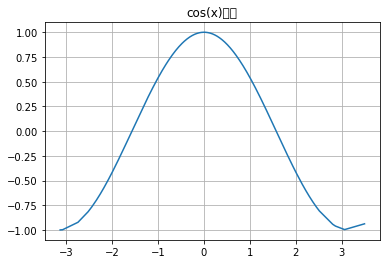

In [63]:
# 准备数据，x代表弧度
x = np.random.normal(size=1000)
# 升序排序
x.sort()
y = np.cos(x)

# 绘制余弦曲线
plt.plot(x,y)
plt.grid()
plt.title('cos(x)曲线')
plt.show()


#### 从余弦曲线可以看出：在[0°, 90°]之间，AB之间夹角越大, 余弦值越小。余弦距离(1-余弦相似度)就越大，则欧氏距离的平方(2×余弦距离)就越大。




### 6.1.2 L2范式归一化——掉包及代码复现计算过程

In [64]:
x = np.array([[4,1,2,2],[1,3,9,3],[5,7,5,1]])
# 默认是12范式
norm_x = Normalizer().fit_transform(x)
print(norm_x)

[[0.8 0.2 0.4 0.4]
 [0.1 0.3 0.9 0.3]
 [0.5 0.7 0.5 0.1]]


In [65]:
# 复现Normalizer的12范式归一化计算过程
x = np.array([[4,1,2,2],[1,3,9,3],[5,7,5,1]])
norm_x = []

for i in range(len(x)):
    row = x[i]
    sum_row_sqrt = ((row ** 2).sum()) ** 0.5
    temp = row / sum_row_sqrt
    norm_x.append(temp)

print('x:\n', x)
print('norm_x:\n', np.array(norm_x))

x:
 [[4 1 2 2]
 [1 3 9 3]
 [5 7 5 1]]
norm_x:
 [[0.8 0.2 0.4 0.4]
 [0.1 0.3 0.9 0.3]
 [0.5 0.7 0.5 0.1]]




## 6.2 对全量文本的TF-IDF进行范式归一化



#### 需要在使用k-means之前，tfidf矩阵normalize成单位长度(unit norm)，以便K-Means根据tf-idf进行聚类

In [66]:
transfer = Normalizer()
scaled_array = transfer.fit_transform(tfidf.toarray())

In [67]:
ic(type(scaled_array))
scaled_array.shape

ic| type(scaled_array): <class 'numpy.ndarray'>


(87052, 884)



## 6.3 对全量文本进行K-Means聚类



#### 由于数据集较大，先用K-Means进行聚类降维，比如聚类成25堆。后面统计余弦相似度时，抄袭新闻只和自己堆里真实新闻进行计算，有效减少计算量。

In [68]:
# 25是人工规定的桶的个数，把87052个样本按照距离分成25类
estimator2 = KMeans(n_clusters=25)

In [69]:
%%time
estimator2.fit(scaled_array)

Wall time: 1min 31s


KMeans(n_clusters=25)

In [70]:
k_labels = estimator2.predict(scaled_array)
ic(k_labels.shape)
k_labels[:5]

ic| k_labels.shape: (87052,)


array([13, 13, 13,  2, 13])



## 6.4 建立聚类类别与实为新华社文章的index之间的映射关系

#### 创建class_id字典的key是25个类别编号，字典的value是集合，储存的是实际为新华社文章的样本index。

In [71]:
# 将预测的k_labels转为Series类型
k_labels_sr = pd.Series(k_labels)

In [72]:
# id_class = {index: class_ for index, class_ in enumerate(k_labels)}

ic(type(k_labels_sr))
k_labels_sr[:5]

ic| type(k_labels_sr): <class 'pandas.core.series.Series'>


0    13
1    13
2    13
3     2
4    13
dtype: int32

In [73]:
class_id = defaultdict(set)

# 调用Series的实例方法items()，返回(index, value)对的迭代器
for index,value in k_labels_sr.items():
    # 只统计实际是新华社的index
    if index in xinhuashe_news_index:
        class_id[value].add(index)

In [74]:
# 字典的key是0~24的25个类别编号，字典的value是集合
class_id.keys()

dict_keys([2, 13, 14, 22, 9, 16, 20, 0, 3, 12, 4, 24, 1, 10, 11, 5, 18, 21, 17, 8, 6, 19, 23, 15, 7])

In [75]:
ic(type(class_id[12]))
len(class_id[12])

ic| type(class_id[12]): <class 'set'>


2356

## 7 查看相似文章
cosine_similarity(X, Y=None, dense_output=True)                                                               

Y如果不为空，则X、Y的形状需要相同                                                                        
dense_output:布尔值(可选)，默认为True，表示当输入是稀疏的时候是否返回稠密的输出。如果“False”，若两个输入数组都是稀疏的，则输出是稀疏的。   
计算X和Y中样本之间的余弦相似度。                                                                         

余弦相似度或余弦内核将相似度计算为X和Y的标准化点积：                                                                        

$ K(X，Y)= &lt;X，Y&gt; / (|| X || * || Y ||)$                                                        

在L2归一化的数据上，此函数等效于linear_kernel。                                                               

In [76]:

# 在87052则新闻中，选择index为3352的这篇新闻，模型预测风格与新华社相似
copy_news_index.loc[3352]

prediction    1
labels        0
Name: 3352, dtype: int32

In [77]:
print(tfidf[3352].shape)

(1, 884)


稀疏矩阵tfidf[3352]的数据:                                                                                 

  (0, 823)    0.06610655545154177                                                                         
  (0, 822)    0.019203123817457014                                                                       
 ...                                                                                             
  (0, 11)    0.010484988229067377                                                                        
  (0, 5)    0.026698833875343036                                                                         




## 7.1 计算新闻之间的余弦相似度

In [79]:
# 作为疑似抄袭的新闻，
copy_index = 3352

# 先找到它在聚类后的桶的编号，
label = k_labels_sr[copy_index]

ic(label)

# 再计算它的余弦相似度，49153为聚类后同一个label下的一则真实新华社新闻的index
cosine_similarity(tfidf[copy_index],tfidf[49153])

ic| label: 20


array([[0.00458121]])

In [80]:
# 与3352新闻在一个桶里的新华社新闻一共有1698则
news_index_demo = class_id[label]
ic(type(news_index_demo))
len(news_index_demo)

ic| type(news_index_demo): <class 'set'>


1698

In [81]:
# news_index_demo为集合不支持切片，故转为list
list(news_index_demo)[:5]

[16389, 24582, 32774, 65544, 49161]

In [84]:
def find_similar_text(copy_index,top=10):
    # 只在新华社发布的文章中查找
    label = k_labels_sr[copy_index]
    dist_dict = {i:cosine_similarity(tfidf[copy_index],tfidf[i]) for i in class_id[label]}
    
    # 从大到小排序
    return sorted(dist_dict.items(),key=lambda x:x[1][0], reverse=True)[:top]

In [85]:
similar_list = find_similar_text(copy_index)

ic(len(similar_list))
similar_list

ic| len(similar_list): 10


[(3134, array([[0.96848961]])),
 (63509, array([[0.94642972]])),
 (29439, array([[0.94283134]])),
 (3218, array([[0.87621302]])),
 (980, array([[0.87534597]])),
 (29613, array([[0.86935867]])),
 (29886, array([[0.8621539]])),
 (64044, array([[0.85277574]])),
 (29775, array([[0.84875245]])),
 (63972, array([[0.73415204]]))]



## 7.2 查看抄袭新闻与新华社原文

In [86]:
print('怀疑是抄袭的新闻:\n',df.iloc[copy_index].content)

怀疑是抄袭的新闻:
 　　中国5月份56座城市新建商品住宅价格环比上涨，4月份为58座上涨。5月份15个一线和热点二线城市房地产市场基本稳定，5月份房地产调控政策效果继续显现。
　　统计局：15个一线和热点二线城市房价同比涨幅全部回落
　　国家统计局城市司高级统计师刘建伟解读5月份房价数据
　　5月份一二线城市房价平均涨幅继续回落
　　国家统计局今日发布了2017年5月份70个大中城市住宅销售价格统计数据。对此，国家统计局城市司高级统计师刘建伟进行了解读。
　　一、15个一线和热点二线城市新建商品住宅价格同比涨幅全部回落、9个城市环比下降或持平
　　5月份，因地制宜、因城施策的房地产调控政策效果继续显现，15个一线和热点二线城市房地产市场基本稳定。从同比看，15个城市新建商品住宅价格涨幅均比上月回落，回落幅度在0.5至6.4个百分点之间。从环比看，9个城市新建商品住宅价格下降或持平；5个城市涨幅在0.5%以内。
　　二、70个大中城市中一二线城市房价同比涨幅持续回落
　　5月份，70个城市中新建商品住宅和二手住宅价格同比涨幅比上月回落的城市分别有29和18个。其中，一二线城市同比涨幅回落尤其明显。据测算，一线城市新建商品住宅和二手住宅价格同比涨幅均连续8个月回落，5月份比4月份分别回落2.2和1.7个百分点；二线城市新建商品住宅和二手住宅价格同比涨幅分别连续6个月和4个月回落，5月份比4月份分别回落0.8和0.5个百分点。
　　三、70个大中城市中房价环比下降及涨幅回落城市个数均有所增加
　　5月份，70个城市中新建商品住宅价格环比下降的城市有9个，比上月增加1个；涨幅回落的城市有26个，比上月增加3个。二手住宅价格环比下降的城市有7个，比上月增加2个；涨幅回落的城市有30个，比上月增加8个。



In [87]:
# 找一篇相似的新华社原文
similar2 = similar_list[0][0]
print("相似原文:\n",df.iloc[similar2].content)

相似原文:
 　　国家统计局19日发布数据，5月份，15个一线和热点二线城市新建商品住宅价格同比涨幅全部回落，其中9个城市环比下降或持平。这9个价格环比下降或持平的城市为：北京、上海、南京、杭州、合肥、福州、郑州、深圳、成都。
　　“5月份，因地制宜、因城施策的房地产调控政策效果继续显现，15个一线和热点二线城市房地产市场基本稳定。”国家统计局城市司高级统计师刘建伟说，从同比看，15个城市新建商品住宅价格涨幅均比上月回落，回落幅度在0.5至6.4个百分点之间。从环比看，9个城市新建商品住宅价格下降或持平；5个城市涨幅在0.5%以内。
　　国家统计局当天还发布了5月份70个大中城市住宅销售价格统计数据。刘建伟介绍，5月份，70个大中城市中新建商品住宅和二手住宅价格同比涨幅比上月回落的城市分别有29和18个。其中，一二线城市同比涨幅回落尤其明显。据测算，一线城市新建商品住宅和二手住宅价格同比涨幅均连续8个月回落，5月份比4月份分别回落2.2和1.7个百分点；二线城市新建商品住宅和二手住宅价格同比涨幅分别连续6个月和4个月回落，5月份比4月份分别回落0.8和0.5个百分点。
　　此外，70个大中城市中房价环比下降及涨幅回落城市个数均有所增加。统计显示，5月份，70个大中城市中新建商品住宅价格环比下降的城市有9个，比上月增加1个；涨幅回落的城市有26个，比上月增加3个。二手住宅价格环比下降的城市有7个，比上月增加2个；涨幅回落的城市有30个，比上月增加8个。



In [88]:
# 找一篇相似新华社的原文
similar3 = similar_list[1][0]
print("相似原文:\n",df.iloc[similar3].content)

相似原文:
 　　新华社北京5月18日电国家统计局18日发布的数据显示，4月份，15个一线和热点二线城市新建商品住宅价格同比涨幅回落，9个城市环比下降或持平。\n　　这9个价格环比下降或持平的城市是天津、上海、南京、合肥、福州、杭州、厦门、深圳、成都。\n　　“4月份，因地制宜、因城施策的房地产调控政策继续发挥作用。”国家统计局城市司高级统计师刘建伟说，从同比看，15个城市新建商品住宅价格涨幅均比上月回落，回落幅度在0.7至7.4个百分点之间。从环比看，9个城市新建商品住宅价格下降或持平；5个城市涨幅回落，回落幅度在0.2至1.1个百分点之间。\n　　国家统计局当天还发布了4月份70个大中城市住宅销售价格统计数据。刘建伟介绍，从同比看，4月份70个城市中有30个城市新建商品住宅价格涨幅比上月回落，比3月份增加6个，回落城市中23个为一二线城市。初步测算，一线城市新建商品住宅价格同比涨幅连续7个月回落，4月份比3月份回落2.8个百分点；二线城市新建商品住宅价格同比涨幅连续5个月回落，4月份比3月份回落1.0个百分点；三线城市新建商品住宅价格同比涨幅略有扩大，4月份比3月份扩大0.4个百分点。\n　　从环比看，4月份70个城市中有23个城市新建商品住宅价格涨幅比上月回落，比3月份增加13个；7个城市由上月上涨转为持平或下降；3个城市降幅扩大。（完）


# 8 总结：

1、文档查重时，需要统计逆向文档率TF-IDF (API: TfidfTransformer())；                                                  
2、文档之间的相似度统计需要通过余弦相似度进行 (API: cosine_similarity())；                                             
3、当对TF-IDF进行K-Means聚类时，需要先对它进行范式归一化(API: Normalizer());详细原因见6.1节。                                 